In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, plot_det_curve
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV
import pickle as pkl
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
data = pd.read_csv('maladie_cardiaque.csv', usecols=lambda column: column != 'Unnamed: 0',index_col = 'id')

In [3]:
def transform_dataframe(data):
    # Ajouter une colonne 'age_annee'
    data["age_annee"] = round(data["age"]/365.25,2)

    # Créer les intervalles pour les classes d'âge
    bins = [0, 18, 30, 45, 60, 100]

    # Créer les étiquettes pour les classes d'âge
    labels = ['moins de 18 ans', '18-30 ans', '30-45 ans', '45-60 ans', 'plus de 60 ans']

    # Créer une nouvelle colonne 'classe_age' en utilisant la méthode cut()
    data['classe_age'] = pd.cut(data['age_annee'], bins=bins, labels=labels)

    # Convertir les colonnes 'malade', 'fumeur' et 'conso_alco' en 0/1
    data['malade'] = data["malade"].map({'oui': 1, 'non': 0})
    data['fumeur'] = data["fumeur"].map({'fumeur': 1, 'non fumeur': 0})
    data['conso_alco'] = data["conso_alco"].map({'oui': 1, 'non': 0})

    # Ajouter une colonne 'IMC_Category'
    def imc_category(row):
        taille_m = row['taille'] / 100  # Convertir la taille en mètres
        imc = row['Poids'] / (taille_m ** 2)  # Calculer l'IMC
        if imc < 18.5:
            return 'Maigre'
        elif imc < 25:
            return 'Normal'
        elif imc < 30:
            return 'Surpoids'
        else:
            return 'Obèse'
    data['IMC'] = data.apply(lambda row: row['Poids'] / ((row['taille'] / 100) ** 2), axis=1)
    data['IMC_Category'] = data.apply(imc_category, axis=1)


    # Appliquer get_dummies sur les colonnes catégorielles
    cat_cols = data.select_dtypes(exclude=['int64', 'float64']).columns
    cat_cols = list(cat_cols)
    cat_cols.append("glycemie")
    df_onehot = pd.get_dummies(data, columns=cat_cols)

    # Supprimer les colonnes non nécessaires
    df_onehot = df_onehot.drop(['classe_age_moins de 18 ans','genre_homme', 'age_annee', 'age', 'Poids', 'taille','IMC'], axis=1)

    return df_onehot


In [4]:
df = transform_dataframe(data)

In [12]:
with open('rfecv.pkl', 'rb') as file:
      
    # Call load method to deserialze
    rfe = pkl.load(file)

In [13]:
X = df.drop('malade', axis=1)
y = df['malade']

In [14]:
X = rfe.transform(X)
# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


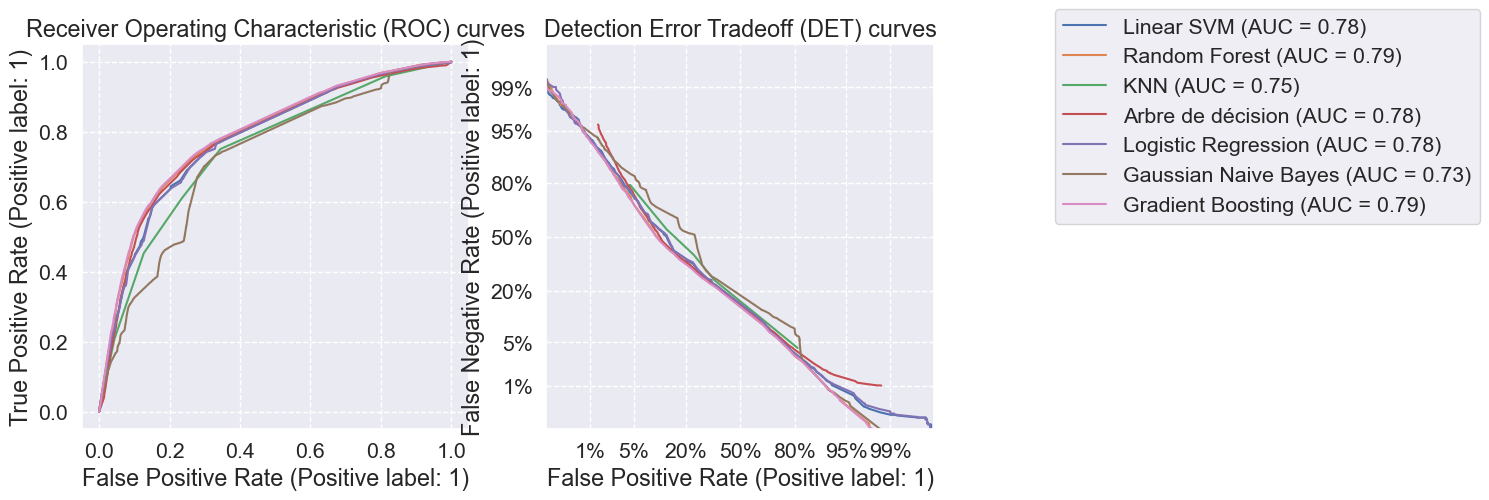

In [70]:
classifiers = {
    "Linear SVM": make_pipeline(LinearSVC(C=0.025)),
    "Random Forest": RandomForestClassifier(**grid_search.best_params_),
    "KNN" : KNeighborsClassifier(n_neighbors=5),
    "Arbre de décision": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier()
}


from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

# Supprimer les légendes ajoutées par RocCurveDisplay et DetCurveDisplay
for ax in [ax_roc, ax_det]:
    ax.legend_.remove()

# Créer une seule légende pour les deux graphiques à droite de la figure
lines, labels = ax_roc.get_legend_handles_labels()
fig.legend(lines, labels, loc='lower left', bbox_to_anchor=(1.0, 0.5))

plt.show()


In [18]:
# Créer un objet RandomForestClassifier avec des paramètres par défaut
rfc = RandomForestClassifier()
param_grid = {'n_estimators': [10, 50, 100, 200],
              'max_depth': [None, 5, 10, 20],
              'max_features': ['auto', 'sqrt']}


# Création de l'objet GridSearchCV
grid_search = GridSearchCV(rfc, param_grid, cv=5)

# Lancement de la recherche de grille avec validation croisée
grid_search.fit(X_train, y_train)

# Affichage des résultats
print("Meilleurs hyperparamètres : ", grid_search.best_params_)
print("Meilleure précision : ", grid_search.best_score_)

Meilleurs hyperparamètres :  {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}
Meilleure précision :  0.7287420042643923


In [19]:
rfc = RandomForestClassifier(**grid_search.best_params_)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200)

In [20]:
y_pred = rfc.predict(X_test)

In [25]:
# Calculer l'accuracy score
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy score : {:.2f}".format(acc_score))

# Calculer le F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score : {:.2f}".format(f1))

# Afficher le classification report
cr = classification_report(y_test, y_pred)
print("Classification report :")
print(cr)

Accuracy score : 0.73
F1 score : 0.73
Classification report :
              precision    recall  f1-score   support

           0       0.71      0.77      0.74     11506
           1       0.75      0.69      0.72     11594

    accuracy                           0.73     23100
   macro avg       0.73      0.73      0.73     23100
weighted avg       0.73      0.73      0.73     23100



Matrice de confusion :


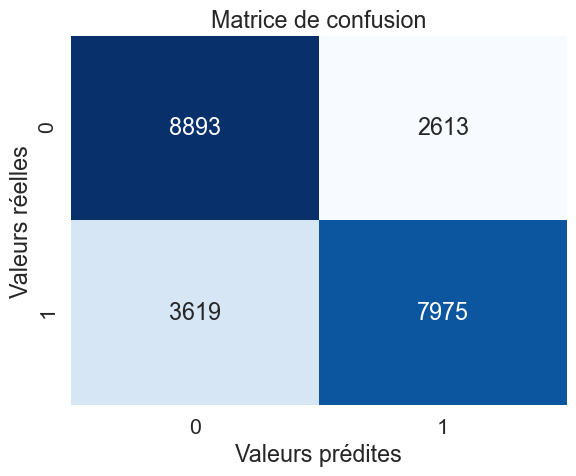

In [28]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")

# Tracer la matrice de confusion avec Seaborn
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matrice de confusion')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

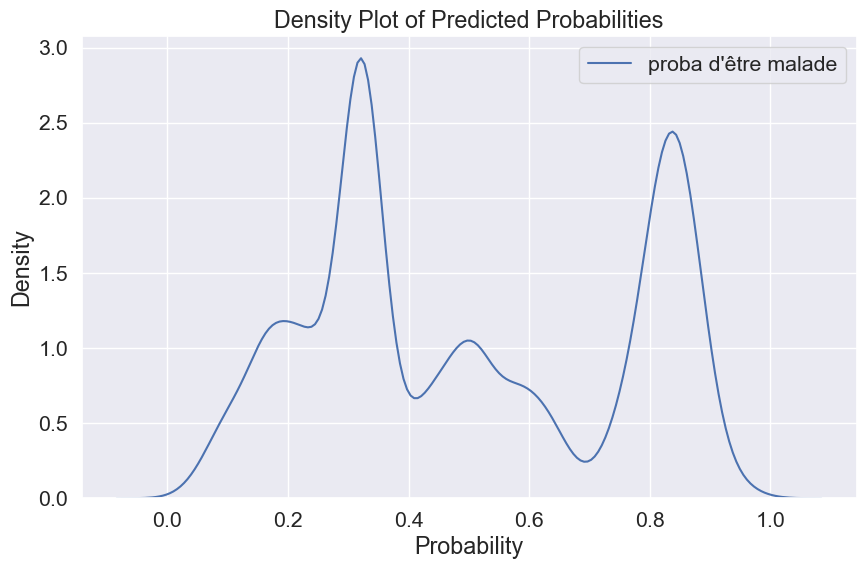

In [29]:
proba_pred  = rfc.predict_proba(X_test)


# créer un graphique de densité pour chaque classe prédite
plt.figure(figsize=(10,6))
sns.kdeplot(proba_pred[:, 1], label="proba d'être malade")
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Density Plot of Predicted Probabilities')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.74      0.67      0.71     11506
           1       0.70      0.77      0.74     11594

    accuracy                           0.72     23100
   macro avg       0.72      0.72      0.72     23100
weighted avg       0.72      0.72      0.72     23100

Matrice de confusion :


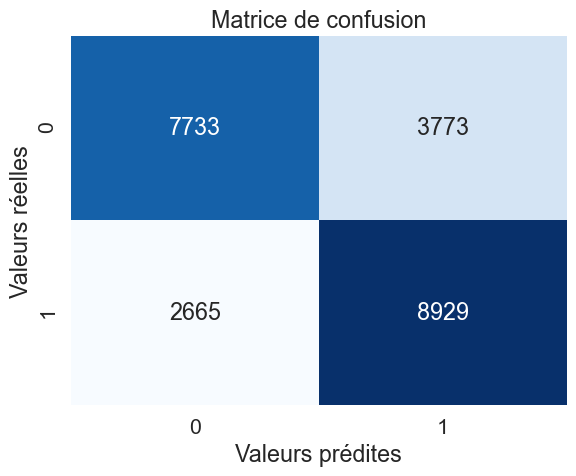

In [33]:

test = []
for prob in proba_pred:
    if prob[1] <0.35:
        test.append(0)
    else:
        test.append(1)
        
print(classification_report(y_test, test))
cm = confusion_matrix(y_test, test)
print("Matrice de confusion :")

# Tracer la matrice de confusion avec Seaborn
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matrice de confusion')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()